# This Is My Third Modeling Notebook

I decided to also try my hand with subreddits of my two favorite TV shows of all time: Mad Men and The Sopranos! I wanted to see if I had a more robust set of data from here compared to the other two notebooks.

This wound up being the top choice for material for this project.

In [279]:
#Grabbing some mates

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.naive_bayes import BernoulliNB
from pandas_profiling import ProfileReport

from nltk.util import ngrams


from sklearn.feature_extraction import text

#### Importing my pulled data

In [59]:
madmen_df = pd.read_csv('./data/total_MadMen.csv')
sopranos_df = pd.read_csv('./data/total_TheSopranos.csv')

In [60]:
madmen_df = madmen_df[['subreddit', 'selftext', 'title']]
sopranos_df = sopranos_df[['subreddit', 'selftext', 'title']]

#### Pandas Profile Reporting

I used the below profile reports to get some insight into my two dataframes before combining the two for my models. I remembered these from David Elliott showing us them.

In [5]:
mad_profile = ProfileReport(madmen_df, title='Mad Men Pandas Profiling Report')
mad_profile

Summarize dataset:   0%|          | 0/16 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

In [6]:
sopranos_profile = ProfileReport(sopranos_df, title='Sopranos Pandas Profiling Report')
sopranos_profile

Summarize dataset:   0%|          | 0/16 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

### Caveats of my subreddits:

I have a lot of null values in the selftext of these subreddits. There's a few reasons for this:

1. There are a lot of images in the body of text for a number of these.


With these in mind, in running my models on these two subreddits, I decided to go with the title and the selftext combined into one feature to see how things went.

In [61]:
# Derya Gumustel and Amir Semsarzadeh helped out by giving me some Regex knowledge
def clean_this_data_please(df):
    # remove those NaNs
    clean_df = df
    clean_df.replace(r'[^a-zA-Z ]\s?',' ',regex=True, inplace=True)
    clean_df.replace(np.nan, " ", regex=True, inplace=True)
    # remove links
    clean_df.replace('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+', ' ', regex=True, inplace=True)
    # remove digits, '&amp;', and forward slashes
    clean_df.replace('\d+', '', regex=True, inplace=True) # help from Amir! 
    clean_df.replace('&amp;', ' ', regex=True, inplace=True)
    clean_df.replace('/', ' ', regex=True, inplace=True)
    # remove new line characters
    clean_df.replace(to_replace=[r'\\t|\\n|\\r', '\t|\n|\r'], value=[' ',' '], regex=True, inplace=True)
    #gotta remove [removed]
    df.replace(r'removed', " ", regex=True, inplace=True)
    #df.replace(r'[]', " ", regex=True, inplace=True)
    return clean_df

In [62]:
clean_this_data_please(madmen_df)

subreddit                                           selftext  \
0       madmen                                                      
1       madmen                                                      
2       madmen                                                      
3       madmen                                                      
4       madmen                                                      
...        ...                                                ...   
2995    madmen                                                      
2996    madmen                                                      
2997    madmen                                                      
2998    madmen    Did Betty call Don  Daddy    Did Megan call ...   
2999    madmen                                                      

                                                  title  
0                                            Love this   
1                                             Hard pass  
2                                    Opinions on Megan   
3                                     My Facebook image  
4                                                 Truth  
...                                                 ...  
2995                                 Rewatching Mad Men  
2996         Season   was this the experimental season   
2997   Apparently there are quite a few men here who...  
2998   The Rick Grimes  Questions about Don s sex life   
2999                                    We are all Glen  

[3000 rows x 3 columns]

In [63]:
clean_this_data_please(sopranos_df)

subreddit                                           selftext  \
0     thesopranos  This is my theory   Jimmy wasn t a rat and lem...   
1     thesopranos                                                      
2     thesopranos  When Mister X the hair apparent is playing che...   
3     thesopranos                                                      
4     thesopranos                                                      
...           ...                                                ...   
2995  thesopranos                                                      
2996  thesopranos                                                      
2997  thesopranos  Who wants to try a Sopranos reading club ie on...   
2998  thesopranos  For me it is Christopher s mom Beyond the chan...   
2999  thesopranos                                                      

                                                  title  
0                       Was Jimmy Altieri really a rat   
1                           Sopranos ending hidden joke  
2      Now see you should ve played that out That s ...  
3                                   Soprano Home movies  
4     Tony was involved in more traffic accidents in...  
...                                                 ...  
2995                                    Figured it out   
2996  Does anyone own The Sopranos Family Cookbook b...  
2997                                 Sopranos Book Club  
2998  Which re casting decision bothers you the most...  
2999             Best favorite lines four words or less  

[3000 rows x 3 columns]

##### I need to fix the don problem with The Sopranos df

I am going to switch 'don' to dont for all instances, since I can't just drop the word since don is the main character in Mad Men. This issue was made apparent when looking at bigrams and trigrams. The last song that plays in The Sopranos is not "Don Stop Believing".

In [64]:
sopranos_df.replace('don', "dont", regex=True, inplace=True)

##### Let's combine the selftext and title data into one total NLP feature for the rest of this.

In [66]:
madmen_df['total_text'] = madmen_df['title'] + madmen_df['selftext']
sopranos_df['total_text'] = sopranos_df['title'] + sopranos_df['selftext']

#### We have some additional stop words that need to be removed:

1. 've' - Unless both are referring to "victory in Europe", I believe this is a non-word that may have been the result of cleaning.
2. I found a number of words to remove from looking at bigrams and trigrams

In [225]:
extra_stop_words = ['ve', 'https', 'reddit', 'imgur', 'amp', 'png', 'format', 'www', 'com', 'jpg', 'org', 'http', 'wiki', 'poll', 'pjpg', 'webp',
                   'youtube', 'hn', 'pzo', 'season', 'watch', 'watching', 'watched', 'series', 'think', 'just', 'scene', 'know', 'time', 'episode',
                   'like', 'did']

In [226]:
stop_words = text.ENGLISH_STOP_WORDS.union(extra_stop_words)

In [227]:
madmen_cvec = CountVectorizer(stop_words= stop_words)

In [228]:
count_madmen_cvec = madmen_cvec.fit_transform(madmen_df['total_text'])

In [229]:
count_madmen_cvec

<3000x10832 sparse matrix of type '<class 'numpy.int64'>'
	with 53732 stored elements in Compressed Sparse Row format>

In [230]:
count_madmen_cvec_df = pd.DataFrame(count_madmen_cvec.todense(), columns=madmen_cvec.get_feature_names())

In [231]:
count_madmen_cvec_df.head()

aa  aaae  aaaf  aac  aaliyah  aaron  ab  aback  abagail  abandon  ...  zoo  \
0   0     0     0    0        0      0   0      0        0        0  ...    0   
1   0     0     0    0        0      0   0      0        0        0  ...    0   
2   0     0     0    0        0      0   0      0        0        0  ...    0   
3   0     0     0    0        0      0   0      0        0        0  ...    0   
4   0     0     0    0        0      0   0      0        0        0  ...    0   

   zoom  zou  zspkwgepgg  zu  zubi  zuko  zuverl  zv  zwrwb  
0     0    0           0   0     0     0       0   0      0  
1     0    0           0   0     0     0       0   0      0  
2     0    0           0   0     0     0       0   0      0  
3     0    0           0   0     0     0       0   0      0  
4     0    0           0   0     0     0       0   0      0  

[5 rows x 10832 columns]

In [232]:
count_madmen_cvec_df.sum().sort_values(ascending=False).head(25)

don           2052
men            612
mad            586
betty          487
peggy          424
really         361
pete           331
roger          323
joan           304
character      278
does           275
love           273
way            258
people         235
draper         227
megan          226
feel           192
life           191
good           187
sally          183
characters     177
want           174
office         173
going          168
got            167
dtype: int64

Alright! Here's the top 25 words from the Mad Men subreddit

In [233]:
sopranos_cvec = CountVectorizer(stop_words=stop_words)

In [234]:
count_sopranos_cvec = sopranos_cvec.fit_transform(sopranos_df['total_text'])

In [235]:
count_sopranos_cvec

<3000x12994 sparse matrix of type '<class 'numpy.int64'>'
	with 66087 stored elements in Compressed Sparse Row format>

In [236]:
count_sopranos_cvec_df = pd.DataFrame(count_sopranos_cvec.todense(), columns=sopranos_cvec.get_feature_names())

In [237]:
count_sopranos_cvec_df.head()

aa  aaabag  aal  aazo  ab  aback  abandont  abandonted  abandonting  \
0   0       0    0     0   0      0         0           0            0   
1   0       0    0     0   0      0         0           0            0   
2   0       0    0     0   0      0         0           0            0   
3   0       0    0     0   0      0         0           0            0   
4   0       0    0     0   0      0         0           0            0   

   abandontment  ...  zoomed  zoomer  zooming  zqgcuqclcqwwvazlaen  zr  zucca  \
0             0  ...       0       0        0                    0   0      0   
1             0  ...       0       0        0                    0   0      0   
2             0  ...       0       0        0                    0   0      0   
3             0  ...       0       0        0                    0   0      0   
4             0  ...       0       0        0                    0   0      0   

   zuppa  zvt  zxyu  zybm  
0      0    0     0     0  
1      0    0     0     0  
2      0    0     0     0  
3      0    0     0     0  
4      0    0     0     0  

[5 rows x 12994 columns]

In [238]:
count_sopranos_cvec_df.sum().sort_values(ascending=False).head(25)

tony        2578
sopranos     523
paulie       392
really       339
phil         323
got          308
way          289
aj           288
dont         286
says         281
guy          278
life         263
junior       262
family       256
does         247
killed       237
chris        235
people       230
thing        227
didn         225
johnny       224
guys         212
carmela      211
end          210
fucking      206
dtype: int64

# Exploratory Data Analysis

We'll get some charts going here for everyone to enjoy.

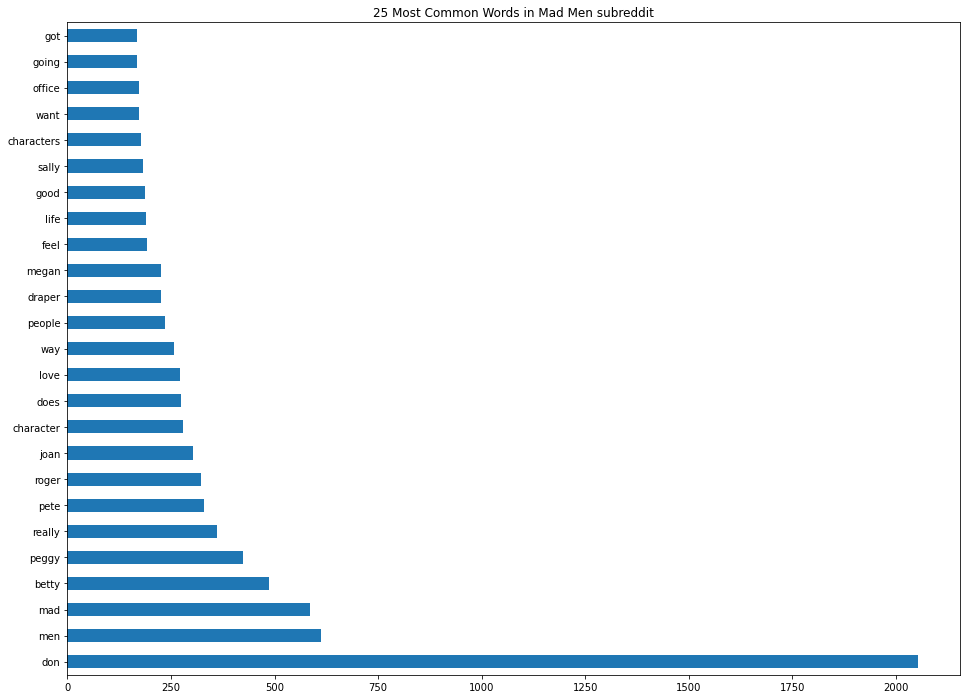

In [240]:
plt.figure(figsize=(16,12))
plt.title('25 Most Common Words in Mad Men subreddit')
count_madmen_cvec_df.sum().sort_values(ascending=False).head(25).plot(kind='barh');

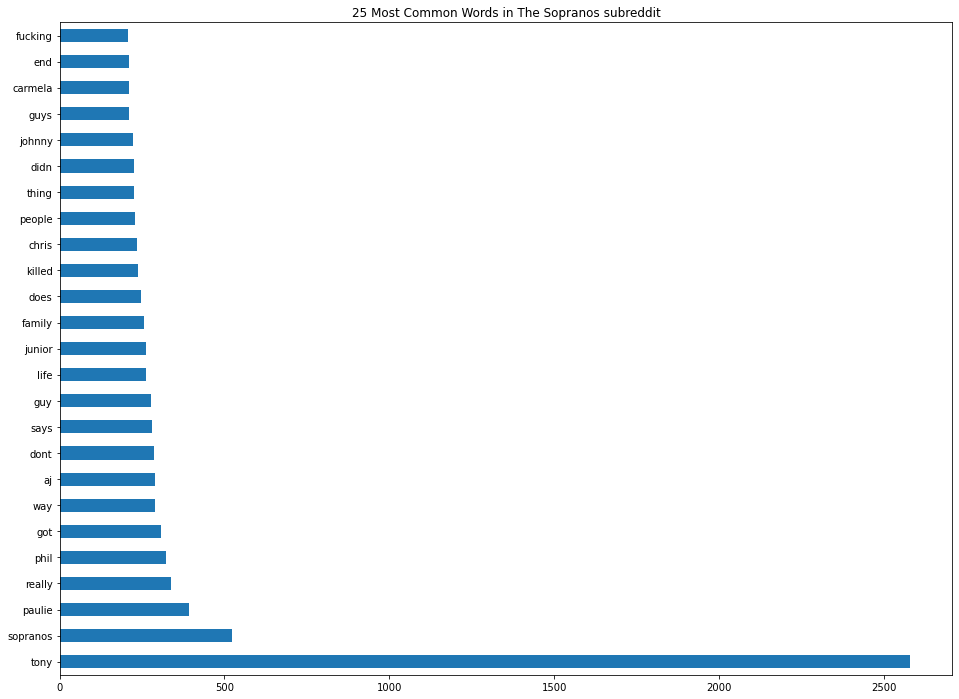

In [241]:
plt.figure(figsize=(16,12))
plt.title('25 Most Common Words in The Sopranos subreddit')
count_sopranos_cvec_df.sum().sort_values(ascending=False).head(25).plot(kind='barh');

#### Bigram time!

Here we are looking at bigrams to see the different two word combos.

In [285]:
bigram_madmen = CountVectorizer(ngram_range=(2,2), stop_words=stop_words)
bigram_madmen_x = bigram_madmen.fit_transform(madmen_df['total_text'])
bigram_madmen_x

<3000x51894 sparse matrix of type '<class 'numpy.int64'>'
	with 59377 stored elements in Compressed Sparse Row format>

In [286]:
bigram_madmen_df = pd.DataFrame(bigram_madmen_x.todense(), columns=bigram_madmen.get_feature_names())

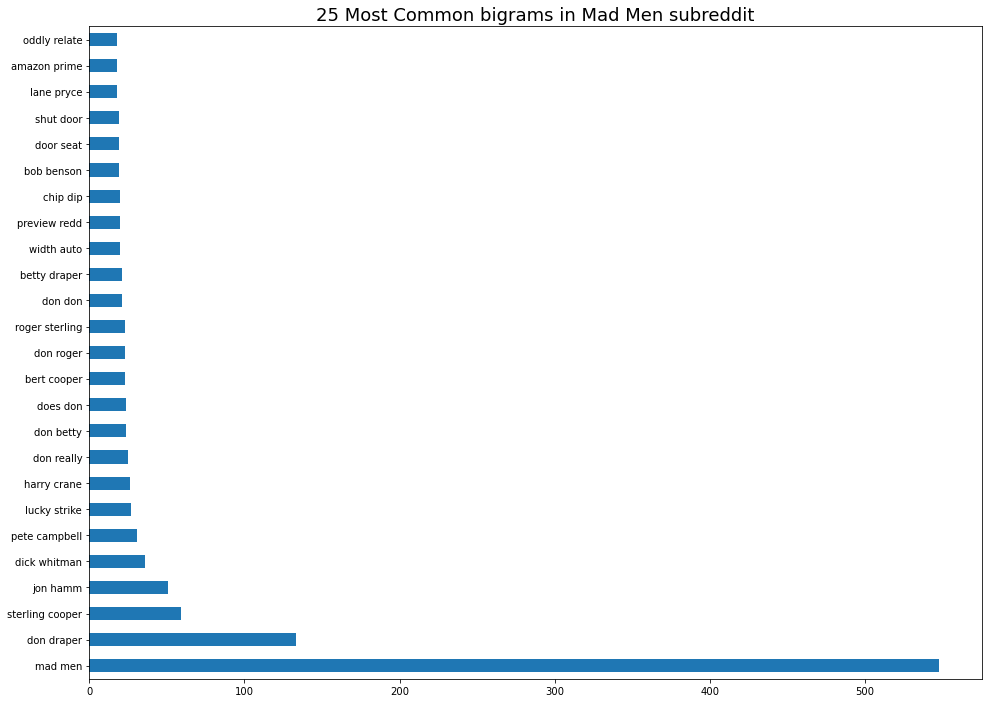

In [321]:
plt.figure(figsize=(16,12))
plt.title('25 Most Common bigrams in Mad Men subreddit', fontdict={'fontsize':18})
bigram_madmen_df.sum().sort_values(ascending=False).head(25).plot(kind='barh')
plt.savefig('./assets/bigrams_madmen.png');

And let's do the same for The Sopranos!

In [289]:
bigram_sopranos = CountVectorizer(ngram_range=(2,2), stop_words=stop_words)
bigram_sopranos_x = bigram_sopranos.fit_transform(sopranos_df['total_text'])
bigram_sopranos_x

<3000x66397 sparse matrix of type '<class 'numpy.int64'>'
	with 75527 stored elements in Compressed Sparse Row format>

In [290]:
bigram_sopranos_df = pd.DataFrame(bigram_sopranos_x.todense(), columns=bigram_sopranos.get_feature_names())

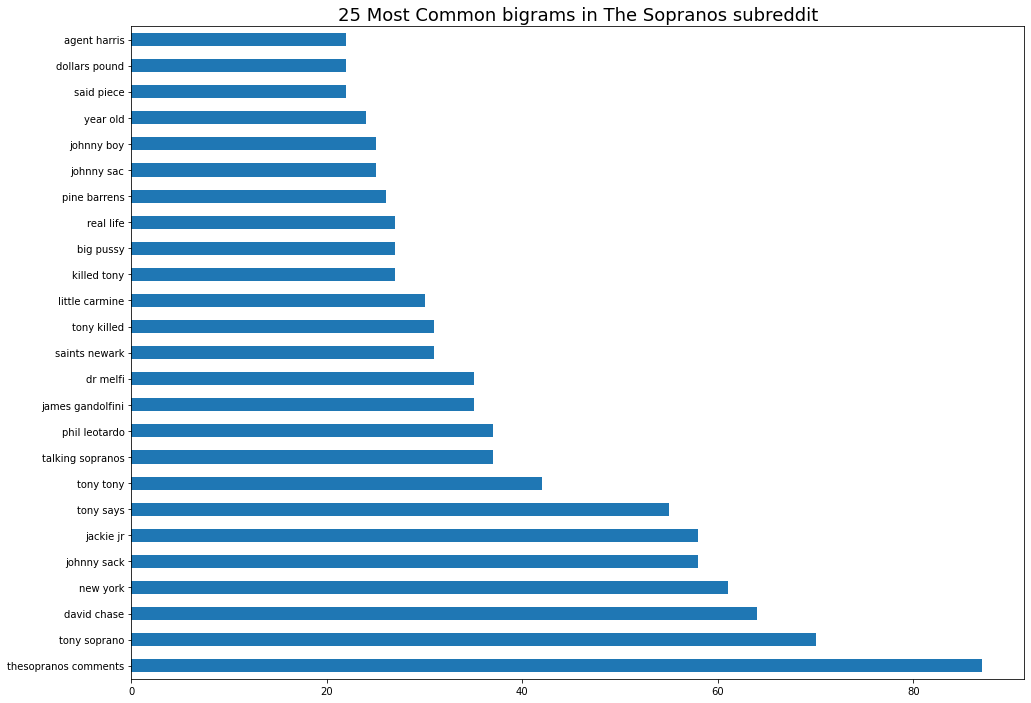

In [319]:
plt.figure(figsize=(16,12))
plt.title('25 Most Common bigrams in The Sopranos subreddit', fontdict={'fontsize':18})
bigram_sopranos_df.sum().sort_values(ascending=False).head(25).plot(kind='barh')
plt.savefig('./assets/bigrams_sopranos.png');

In this process these graphs changed over time since I kept adding words that were either useless (www, https) or 

### Let's explore the data through some trigrams:

I think the combination of words into phrases could be useful here.

In [242]:
trigram_madmen = CountVectorizer(ngram_range=(3,3), stop_words=stop_words)

In [247]:
trigram_madmen_x = trigram_madmen.fit_transform(madmen_df['total_text'])

In [248]:
trigram_madmen_x

<3000x56233 sparse matrix of type '<class 'numpy.int64'>'
	with 57564 stored elements in Compressed Sparse Row format>

In [249]:
trigram_madmen_df = pd.DataFrame(trigram_madmen_x.todense(), columns=trigram_madmen.get_feature_names())

In [250]:
trigram_madmen_df.head()

aa buddy anybody  aa member later  aa recovery devastating  \
0                 0                0                        0   
1                 0                0                        0   
2                 0                0                        0   
3                 0                0                        0   
4                 0                0                        0   

   aa sponsor pond  aaaf fa ae  aac deedd dd  aaliyah hmm tbd  \
0                0           0             0                0   
1                0           0             0                0   
2                0           0             0                0   
3                0           0             0                0   
4                0           0             0                0   

   aaron staton guys  ab df ca  ab fa ad  ...  zou bisou opinion  \
0                  0         0         0  ...                  0   
1                  0         0         0  ...                  0   
2                  0         0         0  ...                  0   
3                  0         0         0  ...                  0   
4                  0         0         0  ...                  0   

   zou bissou conflict  zspkwgepgg vcqj eksmhntdadaho  zu bizu hypocrite  \
0                    0                              0                  0   
1                    0                              0                  0   
2                    0                              0                  0   
3                    0                              0                  0   
4                    0                              0                  0   

   zu thinks getting  zubi zu thinks  zuko sells makes  zuverl ssige gelfirma  \
0                  0               0                 0                      0   
1                  0               0                 0                      0   
2                  0               0                 0                      0   
3                  0               0                 0                      0   
4                  0               0                 0                      0   

   zv pke processing  zwrwb rjyxn zlzwqueg  
0                  0                     0  
1                  0                     0  
2                  0                     0  
3                  0                     0  
4                  0                     0  

[5 rows x 56233 columns]

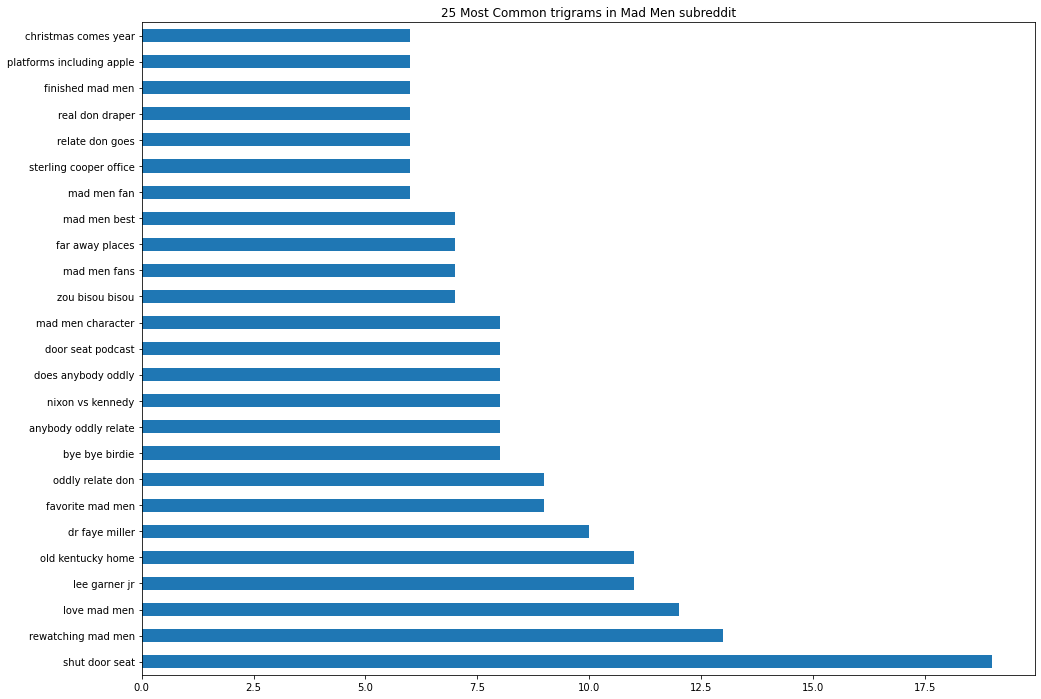

In [251]:
plt.figure(figsize=(16,12))
plt.title('25 Most Common trigrams in Mad Men subreddit')
trigram_madmen_df.sum().sort_values(ascending=False).head(25).plot(kind='barh');

And now let's do some of this for The Sopranos too now.

In [252]:
trigram_sopranos = CountVectorizer(ngram_range=(3,3), stop_words=stop_words)

In [253]:
trigram_sopranos_x = trigram_sopranos.fit_transform(sopranos_df['total_text'])

In [254]:
trigram_sopranos_x

<3000x72998 sparse matrix of type '<class 'numpy.int64'>'
	with 74199 stored elements in Compressed Sparse Row format>

In [255]:
trigram_sopranos_df = pd.DataFrame(trigram_sopranos_x.todense(), columns=trigram_sopranos.get_feature_names())

In [256]:
trigram_sopranos_df.head()

aa ae mid  aa ae second  aa cabca heavier  aa friendcan talk  \
0          0             0                 0                  0   
1          0             0                 0                  0   
2          0             0                 0                  0   
3          0             0                 0                  0   
4          0             0                 0                  0   

   aa meeting talking  aa money pay  aaabag ig qgjpv  aal xs rewatch  \
0                   0             0                0               0   
1                   0             0                0               0   
2                   0             0                0               0   
3                   0             0                0               0   
4                   0             0                0               0   

   aazo ezsy richie  ab channel tonysoprano  ...  zoomer guess gets  \
0                 0                       0  ...                  0   
1                 0                       0  ...                  0   
2                 0                       0  ...                  0   
3                 0                       0  ...                  0   
4                 0                       0  ...                  0   

   zooming bekq xo  zooming wide shots  zqgcuqclcqwwvazlaen lax atonality  \
0                0                   0                                  0   
1                0                   0                                  0   
2                0                   0                                  0   
3                0                   0                                  0   
4                0                   0                                  0   

   zr hlp qiqo  zucca giving great  zuppa di mussels  zvt rewatch toothpick  \
0            0                   0                 0                      0   
1            0                   0                 0                      0   
2            0                   0                 0                      0   
3            0                   0                 0                      0   
4            0                   0                 0                      0   

   zxyu hhxo ab  zybm rewatch toodlefuckingoo  
0             0                             0  
1             0                             0  
2             0                             0  
3             0                             0  
4             0                             0  

[5 rows x 72998 columns]

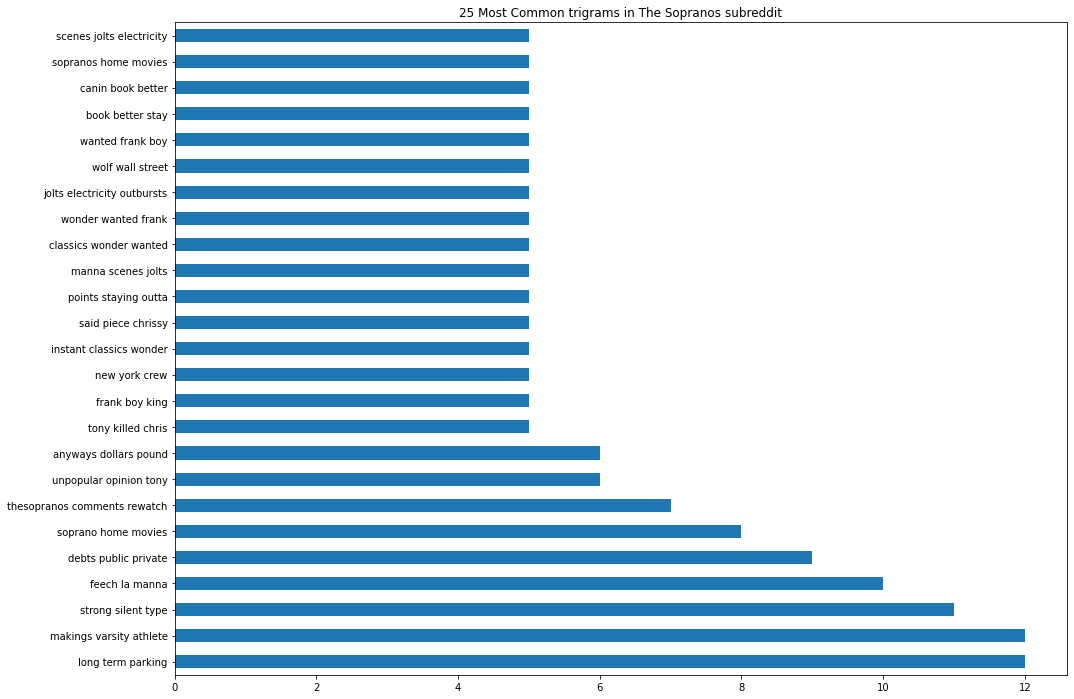

In [257]:
plt.figure(figsize=(16,12))
plt.title('25 Most Common trigrams in The Sopranos subreddit')
trigram_sopranos_df.sum().sort_values(ascending=False).head(25).plot(kind='barh');

### Let's mush these dataframes together

In [258]:
#Set ignore_index to True to get rid of duplicate indexing
all_shows_df = pd.concat([madmen_df, sopranos_df], ignore_index=True)

In [260]:
all_shows_df.shape

(6000, 4)

# The Modeling Begins!

From here on out we are going to see the modeling and how that goes.

In [261]:
X = all_shows_df['total_text']
y = all_shows_df['subreddit']

# Split the data into the training and testing sets.
X_train, X_test, y_train, y_test = train_test_split(X,y, random_state=42)

In [350]:
pipe = Pipeline([
    ('cvec', CountVectorizer(stop_words=stop_words)),
    ('logreg', LogisticRegression())
        
])

In [351]:
pipe.fit(X_train, y_train)

Pipeline(steps=[('cvec',
                 CountVectorizer(stop_words=frozenset({'a', 'about', 'above',
                                                       'across', 'after',
                                                       'afterwards', 'again',
                                                       'against', 'all',
                                                       'almost', 'alone',
                                                       'along', 'already',
                                                       'also', 'although',
                                                       'always', 'am', 'among',
                                                       'amongst', 'amoungst',
                                                       'amount', 'amp', 'an',
                                                       'and', 'another', 'any',
                                                       'anyhow', 'anyone',
                                                       'a

In [352]:
pipe.score(X_train, y_train)

0.9868888888888889

In [353]:
pipe.score(X_test, y_test)

0.9033333333333333

It appears my model is overfit. I am curious as to what is causing the difference.

In [266]:
preds = pipe.predict(X_test)

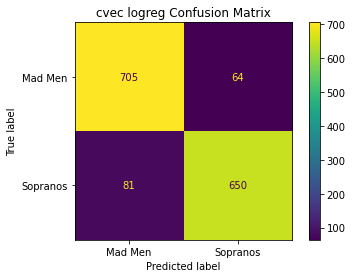

In [305]:
cm = confusion_matrix(y_test, preds)
labels = ['Mad Men', "Sopranos"]
tn, fp, fn, tp = cm.ravel()
ConfusionMatrixDisplay(cm, display_labels=labels).plot()
plt.title('cvec logreg Confusion Matrix')
plt.savefig('./assets/cm_cvec_logreg.png');

Hmm, it seems that there is more parity in the false values in this one, compared to the other.

In [316]:
print(classification_report(y_test, preds))

              precision    recall  f1-score   support

      madmen       0.90      0.92      0.91       769
 thesopranos       0.91      0.89      0.90       731

    accuracy                           0.90      1500
   macro avg       0.90      0.90      0.90      1500
weighted avg       0.90      0.90      0.90      1500



#### Let's try out another model: TfidfVectorizer with Bernoulli Naive Bayes

In [334]:
pipe_tvec_nb = Pipeline([
    ('tvec', TfidfVectorizer(stop_words=stop_words)),
    ('nb', BernoulliNB())
])

In [335]:
pipe_tvec_nb.fit(X_train, y_train)

Pipeline(steps=[('tvec',
                 TfidfVectorizer(stop_words=frozenset({'a', 'about', 'above',
                                                       'across', 'after',
                                                       'afterwards', 'again',
                                                       'against', 'all',
                                                       'almost', 'alone',
                                                       'along', 'already',
                                                       'also', 'although',
                                                       'always', 'am', 'among',
                                                       'amongst', 'amoungst',
                                                       'amount', 'amp', 'an',
                                                       'and', 'another', 'any',
                                                       'anyhow', 'anyone',
                                                       'a

In [336]:
pipe_tvec_nb.score(X_train, y_train)

0.8848888888888888

In [337]:
pipe_tvec_nb.score(X_test, y_test)

0.874

It seems that my scores on the Tfid Bernoulli Naive Bayes has worked well. There is more parity between train and test scores.

In [272]:
pipe_tvec_nb_preds = pipe_tvec_nb.predict(X_test)

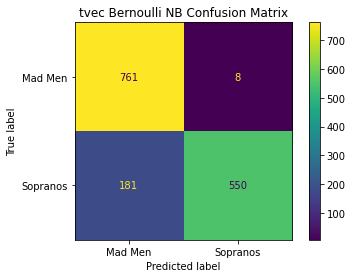

In [318]:
cm = confusion_matrix(y_test, pipe_tvec_nb_preds)
labels = ['Mad Men', "Sopranos"]
tn, fp, fn, tp = cm.ravel()
ConfusionMatrixDisplay(cm, display_labels=labels).plot()
plt.title('tvec Bernoulli NB Confusion Matrix')
plt.savefig('./assets/cm_tvec_bnb.png');

In [273]:
print(classification_report(y_test, pipe_tvec_nb_preds))

              precision    recall  f1-score   support

      madmen       0.81      0.99      0.89       769
 thesopranos       0.99      0.75      0.85       731

    accuracy                           0.87      1500
   macro avg       0.90      0.87      0.87      1500
weighted avg       0.89      0.87      0.87      1500



Oh wow that's an issue. We see that Mad Men is being predicted for The Sopranos too often.

# Going with another model that involves gridsearch

In [322]:
pipe_knn = Pipeline([
    ('cvec', CountVectorizer()),
    ('knn', KNeighborsClassifier())
])

In [97]:
params = {
    'knn__n_neighbors': range(1,100,2),
    'knn__weights': ['uniform', 'distance'],
    'knn__metric': ['euclidean', 'manhattan', 'chebyshev'],
    'knn__algorithm': ['ball_tree', 'kd_tree', 'brute']
}

In [98]:
knn_gs = GridSearchCV(
    pipe_knn,
    params,
    cv=5
)

In [99]:
knn_gs.fit(X_train, y_train)

/Users/umairevans/opt/anaconda3/lib/python3.8/site-packages/sklearn/neighbors/_base.py:462: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: "
/Users/umairevans/opt/anaconda3/lib/python3.8/site-packages/sklearn/neighbors/_base.py:462: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: "
/Users/umairevans/opt/anaconda3/lib/python3.8/site-packages/sklearn/neighbors/_base.py:462: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: "
/Users/umairevans/opt/anaconda3/lib/python3.8/site-packages/sklearn/neighbors/_base.py:462: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: "
/Users/umairevans/opt/anaconda3/lib/python3.8/site-packages/sklearn/neighbors/_base.py:462: UserWarning: cannot use tree with sparse input: using brute 

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('cvec', CountVectorizer()),
                                       ('knn', KNeighborsClassifier())]),
             param_grid={'knn__algorithm': ['ball_tree', 'kd_tree', 'brute'],
                         'knn__metric': ['euclidean', 'manhattan', 'chebyshev'],
                         'knn__n_neighbors': range(1, 100, 2),
                         'knn__weights': ['uniform', 'distance']})

In [100]:
knn_gs.best_score_

0.7342222222222221

In [101]:
knn_gs.best_params_

{'knn__algorithm': 'ball_tree',
 'knn__metric': 'manhattan',
 'knn__n_neighbors': 17,
 'knn__weights': 'distance'}

In [103]:
knn_gs_preds = knn_gs.predict(X_test)

In [105]:
print(classification_report(y_test, knn_gs_preds))

              precision    recall  f1-score   support

      madmen       0.73      0.75      0.74       769
 thesopranos       0.73      0.71      0.72       731

    accuracy                           0.73      1500
   macro avg       0.73      0.73      0.73      1500
weighted avg       0.73      0.73      0.73      1500



In [326]:
pipe_knn_2 = Pipeline([
    ('cvec', CountVectorizer(stop_words=stop_words)),
    ('knn', KNeighborsClassifier(n_neighbors=5))
])

In [327]:
pipe_knn_2.fit(X_train, y_train)

Pipeline(steps=[('cvec',
                 CountVectorizer(stop_words=frozenset({'a', 'about', 'above',
                                                       'across', 'after',
                                                       'afterwards', 'again',
                                                       'against', 'all',
                                                       'almost', 'alone',
                                                       'along', 'already',
                                                       'also', 'although',
                                                       'always', 'am', 'among',
                                                       'amongst', 'amoungst',
                                                       'amount', 'amp', 'an',
                                                       'and', 'another', 'any',
                                                       'anyhow', 'anyone',
                                                       'a

In [328]:
pipe_knn_2.score(X_train, y_train)

0.8306666666666667

In [329]:
pipe_knn_2.score(X_test, y_test)

0.7833333333333333

In [312]:
knn_2_preds = pipe_knn_2.predict(X_test)

In [313]:
print(classification_report(y_test, knn_2_preds))

              precision    recall  f1-score   support

      madmen       0.72      0.94      0.82       769
 thesopranos       0.91      0.61      0.73       731

    accuracy                           0.78      1500
   macro avg       0.82      0.78      0.78      1500
weighted avg       0.81      0.78      0.78      1500



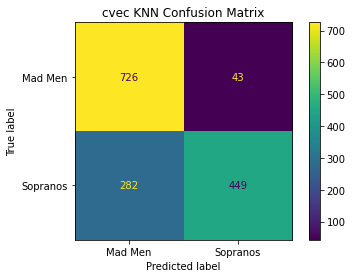

In [317]:
cm = confusion_matrix(y_test, knn_2_preds)
labels = ['Mad Men', "Sopranos"]
tn, fp, fn, tp = cm.ravel()
ConfusionMatrixDisplay(cm, display_labels=labels).plot()
plt.title('cvec KNN Confusion Matrix')
plt.savefig('./assets/cm_cvec_knn.png');